# Example of usage Spark OCR for Checkbox Recognition
In this notebook, we will explore how to apply Visual NER to a document containing checkboxes, and how to post-process the results to obtain keys and values.

In [9]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11/"

import os
if AWS_ACCESS_KEY_ID:
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license

In [ ]:
#!pip install spark-ocr==$version --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

## Initialization of spark session

In [ ]:
from sparkocr import start

spark = start(secret=secret,
              jar_path=spark_ocr_jar_path)
spark

In [3]:
import pkg_resources
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline
import pyspark.sql.functions as f
from sparkocr.utils.helpers import cluster

/home/nmelnik/jupyterlab/my-python39-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load image and display it


    Image #0:
    Origin: file:/home/nmelnik/IdeaProjects/spark-ocr/python/sparkocr/resources/ocr/checkboxes/checkboxes1.png
    Resolution: 0 dpi
    Width: 1700 px
    Height: 2200 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


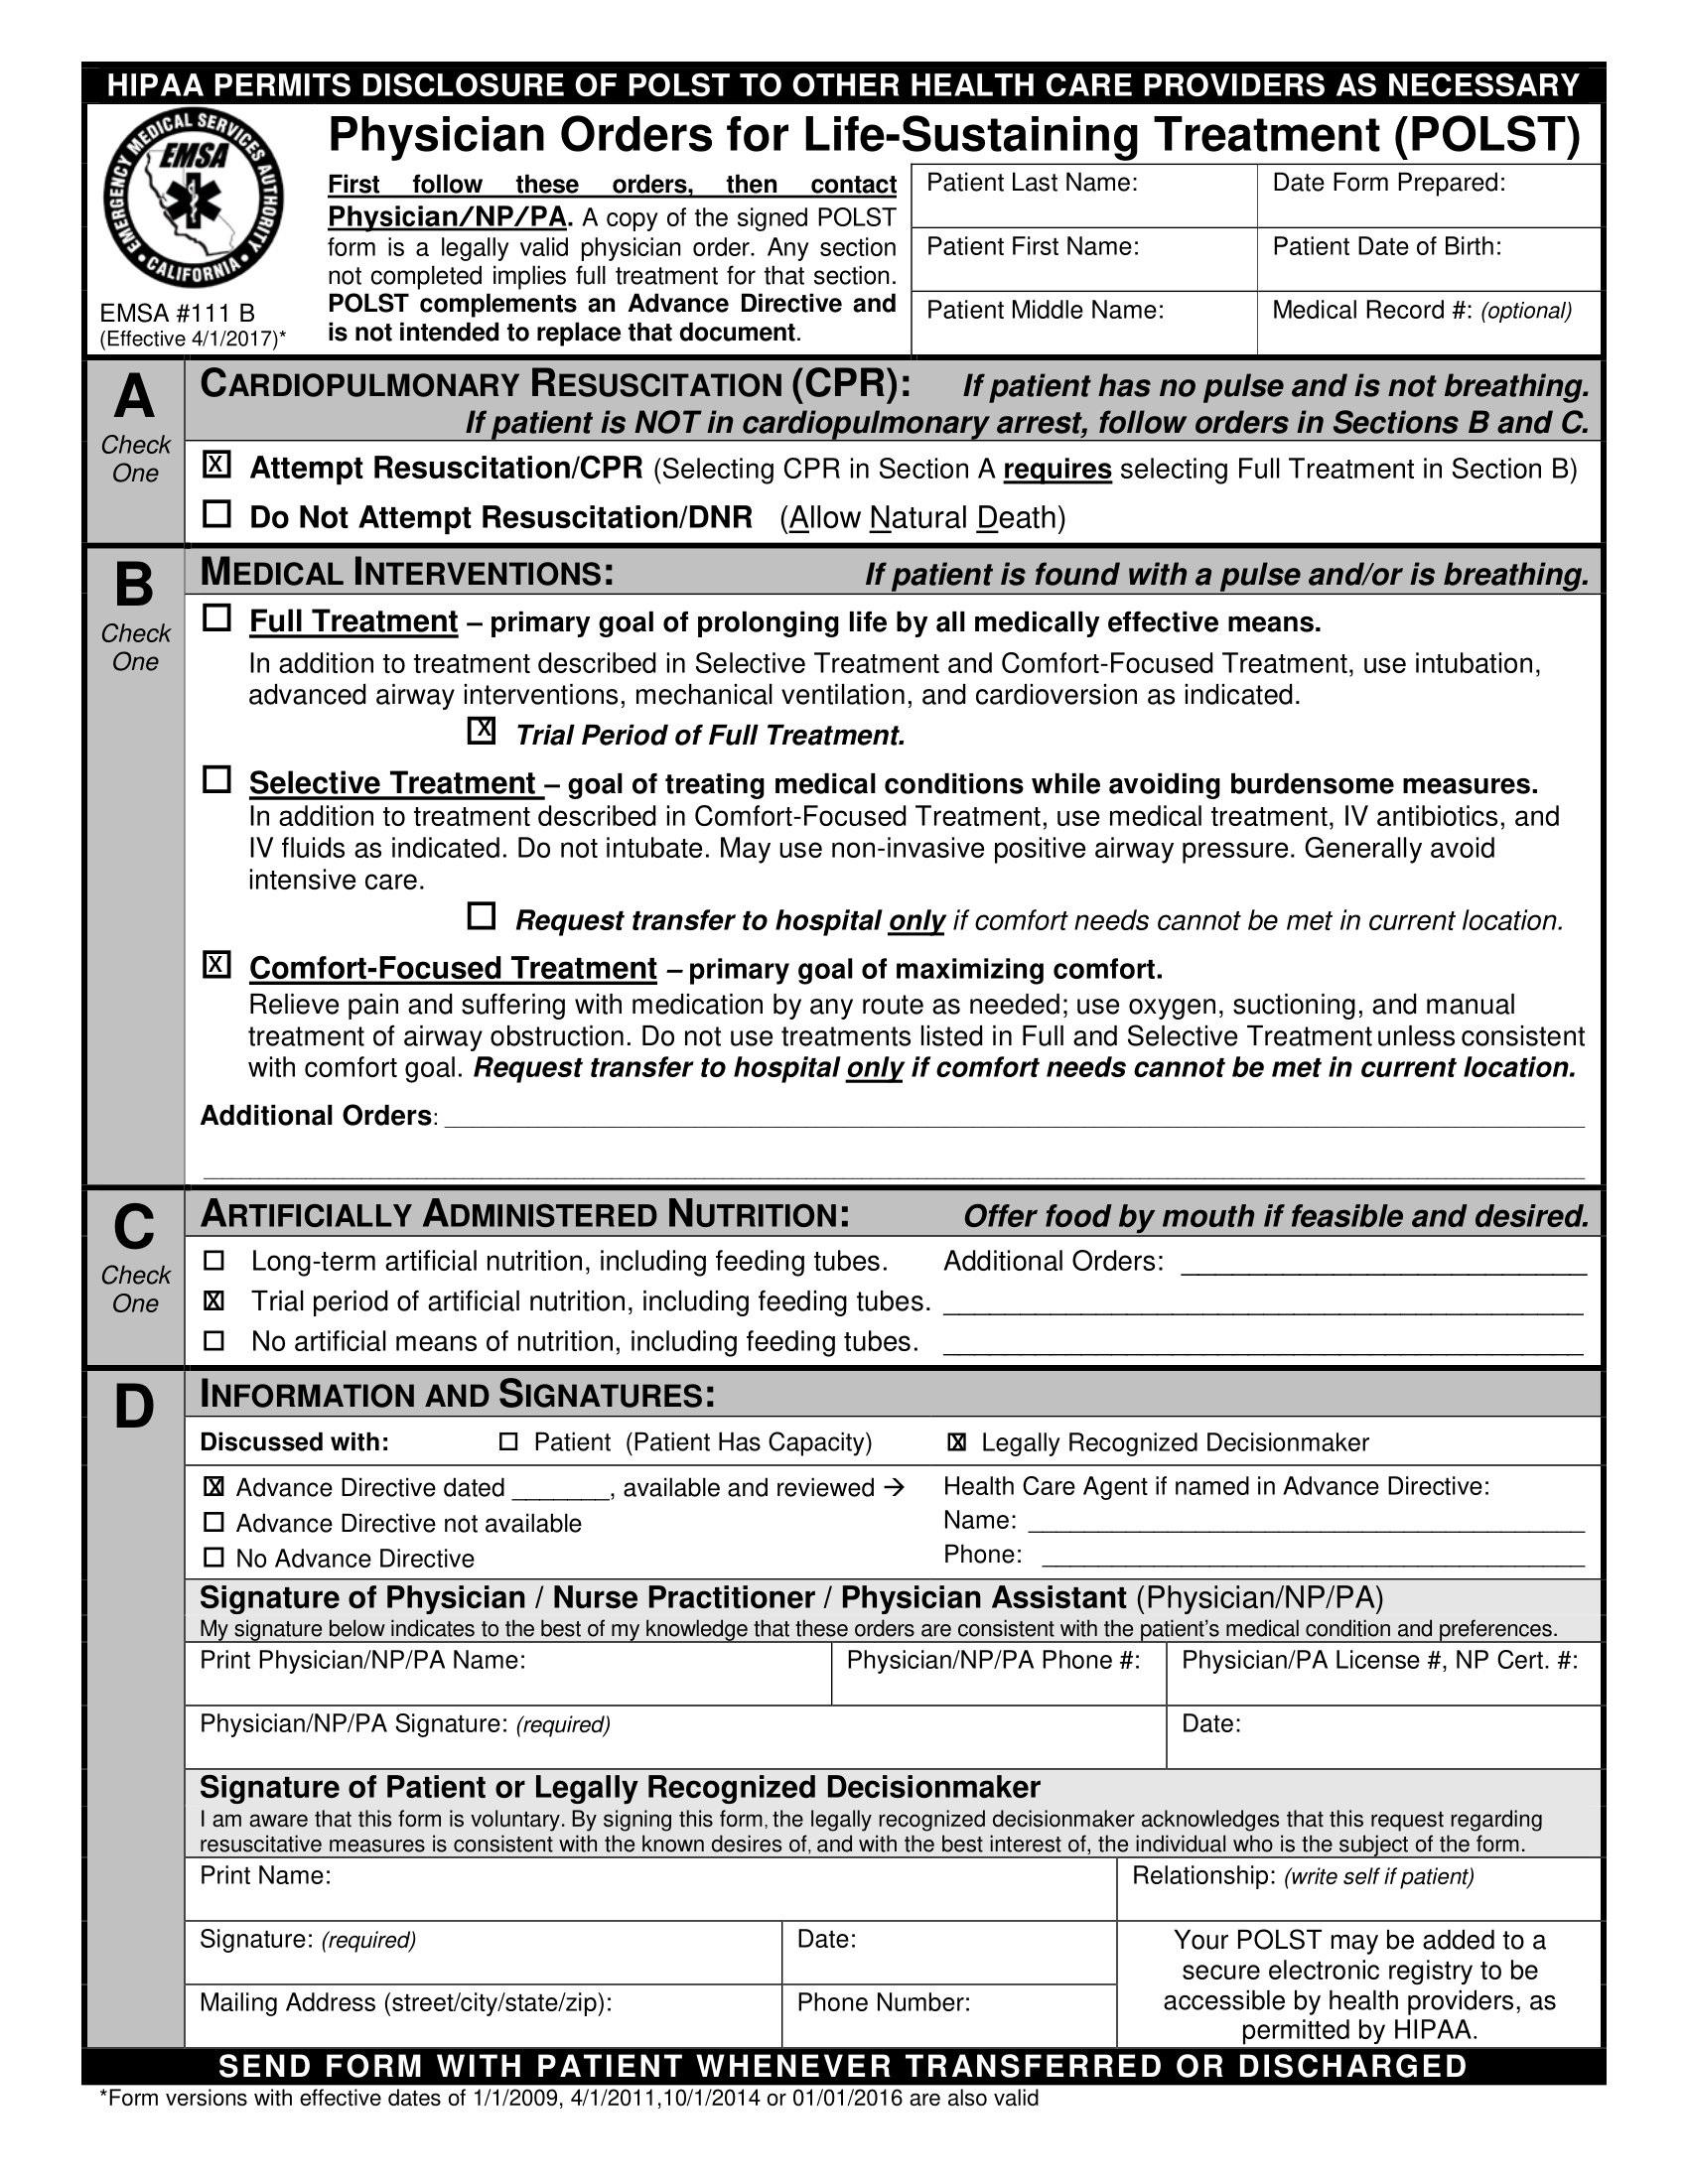

In [4]:
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/checkboxes/checkboxes1.png')
image_df = spark.read.format("binaryFile").load(imagePath).sort("path")

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

## Define pipeline for checkbox recognition

In [5]:
binary_to_image = BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR)

ocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr1") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"]) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)

checkBoxDetector = ImageCheckBoxDetector \
    .pretrained("checkbox_detector_v1", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setLabels(["no", "yes"]) \
    .setOutputLabels(["no", "yes"]) \
    .setScoreThreshold(0.1) \
    .setOutputCol("hocr2") \
    .setOutputFormat(DetectorOutputFormat.HOCR)

hocrMerger = HocrMerger().setOutputCol("hocr").setInputCols(["hocr1", "hocr2"])

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("tokens") \
    .setTokenizerType(TokenizerType.SIMPLE)

drawEntities = ImageDrawAnnotations() \
      .setInputCol("image") \
      .setInputChunksCol("entities") \
      .setOutputCol("image_with_regions") \
      .setFilledRect(False) \
      .setFontSize(20)

visual_ner = VisualDocumentNerLilt() \
      .pretrained("lilt_checkbox_v1", "en", "clinical/ocr") \
      .setInputCols(["tokens", "image"]) \
      .setOutputCol("entities") \
      .setWhiteList(['I-Key', 'I-Value', 'B-Key'])


pipeline = PipelineModel(stages=[
     binary_to_image,
     ocr,
     checkBoxDetector,
     hocrMerger,
     tokenizer,
     visual_ner,
     drawEntities
])

checkbox_detector_v1 download started this may take some time.
Approximate size to download 265.8 MB
checkbox_detector_v1 download started this may take some time.
Approximate size to download 265.8 MB
Download done! Loading the resource.
lilt_checkbox_v1 download started this may take some time.
Approximate size to download 411.4 MB
lilt_checkbox_v1 download started this may take some time.
Approximate size to download 411.4 MB
Download done! Loading the resource.


Estimating resolution as 249



    Image #0:
    Origin: file:/home/nmelnik/IdeaProjects/spark-ocr/python/sparkocr/resources/ocr/checkboxes/checkboxes1.png
    Resolution: 0 dpi
    Width: 1700 px
    Height: 2200 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


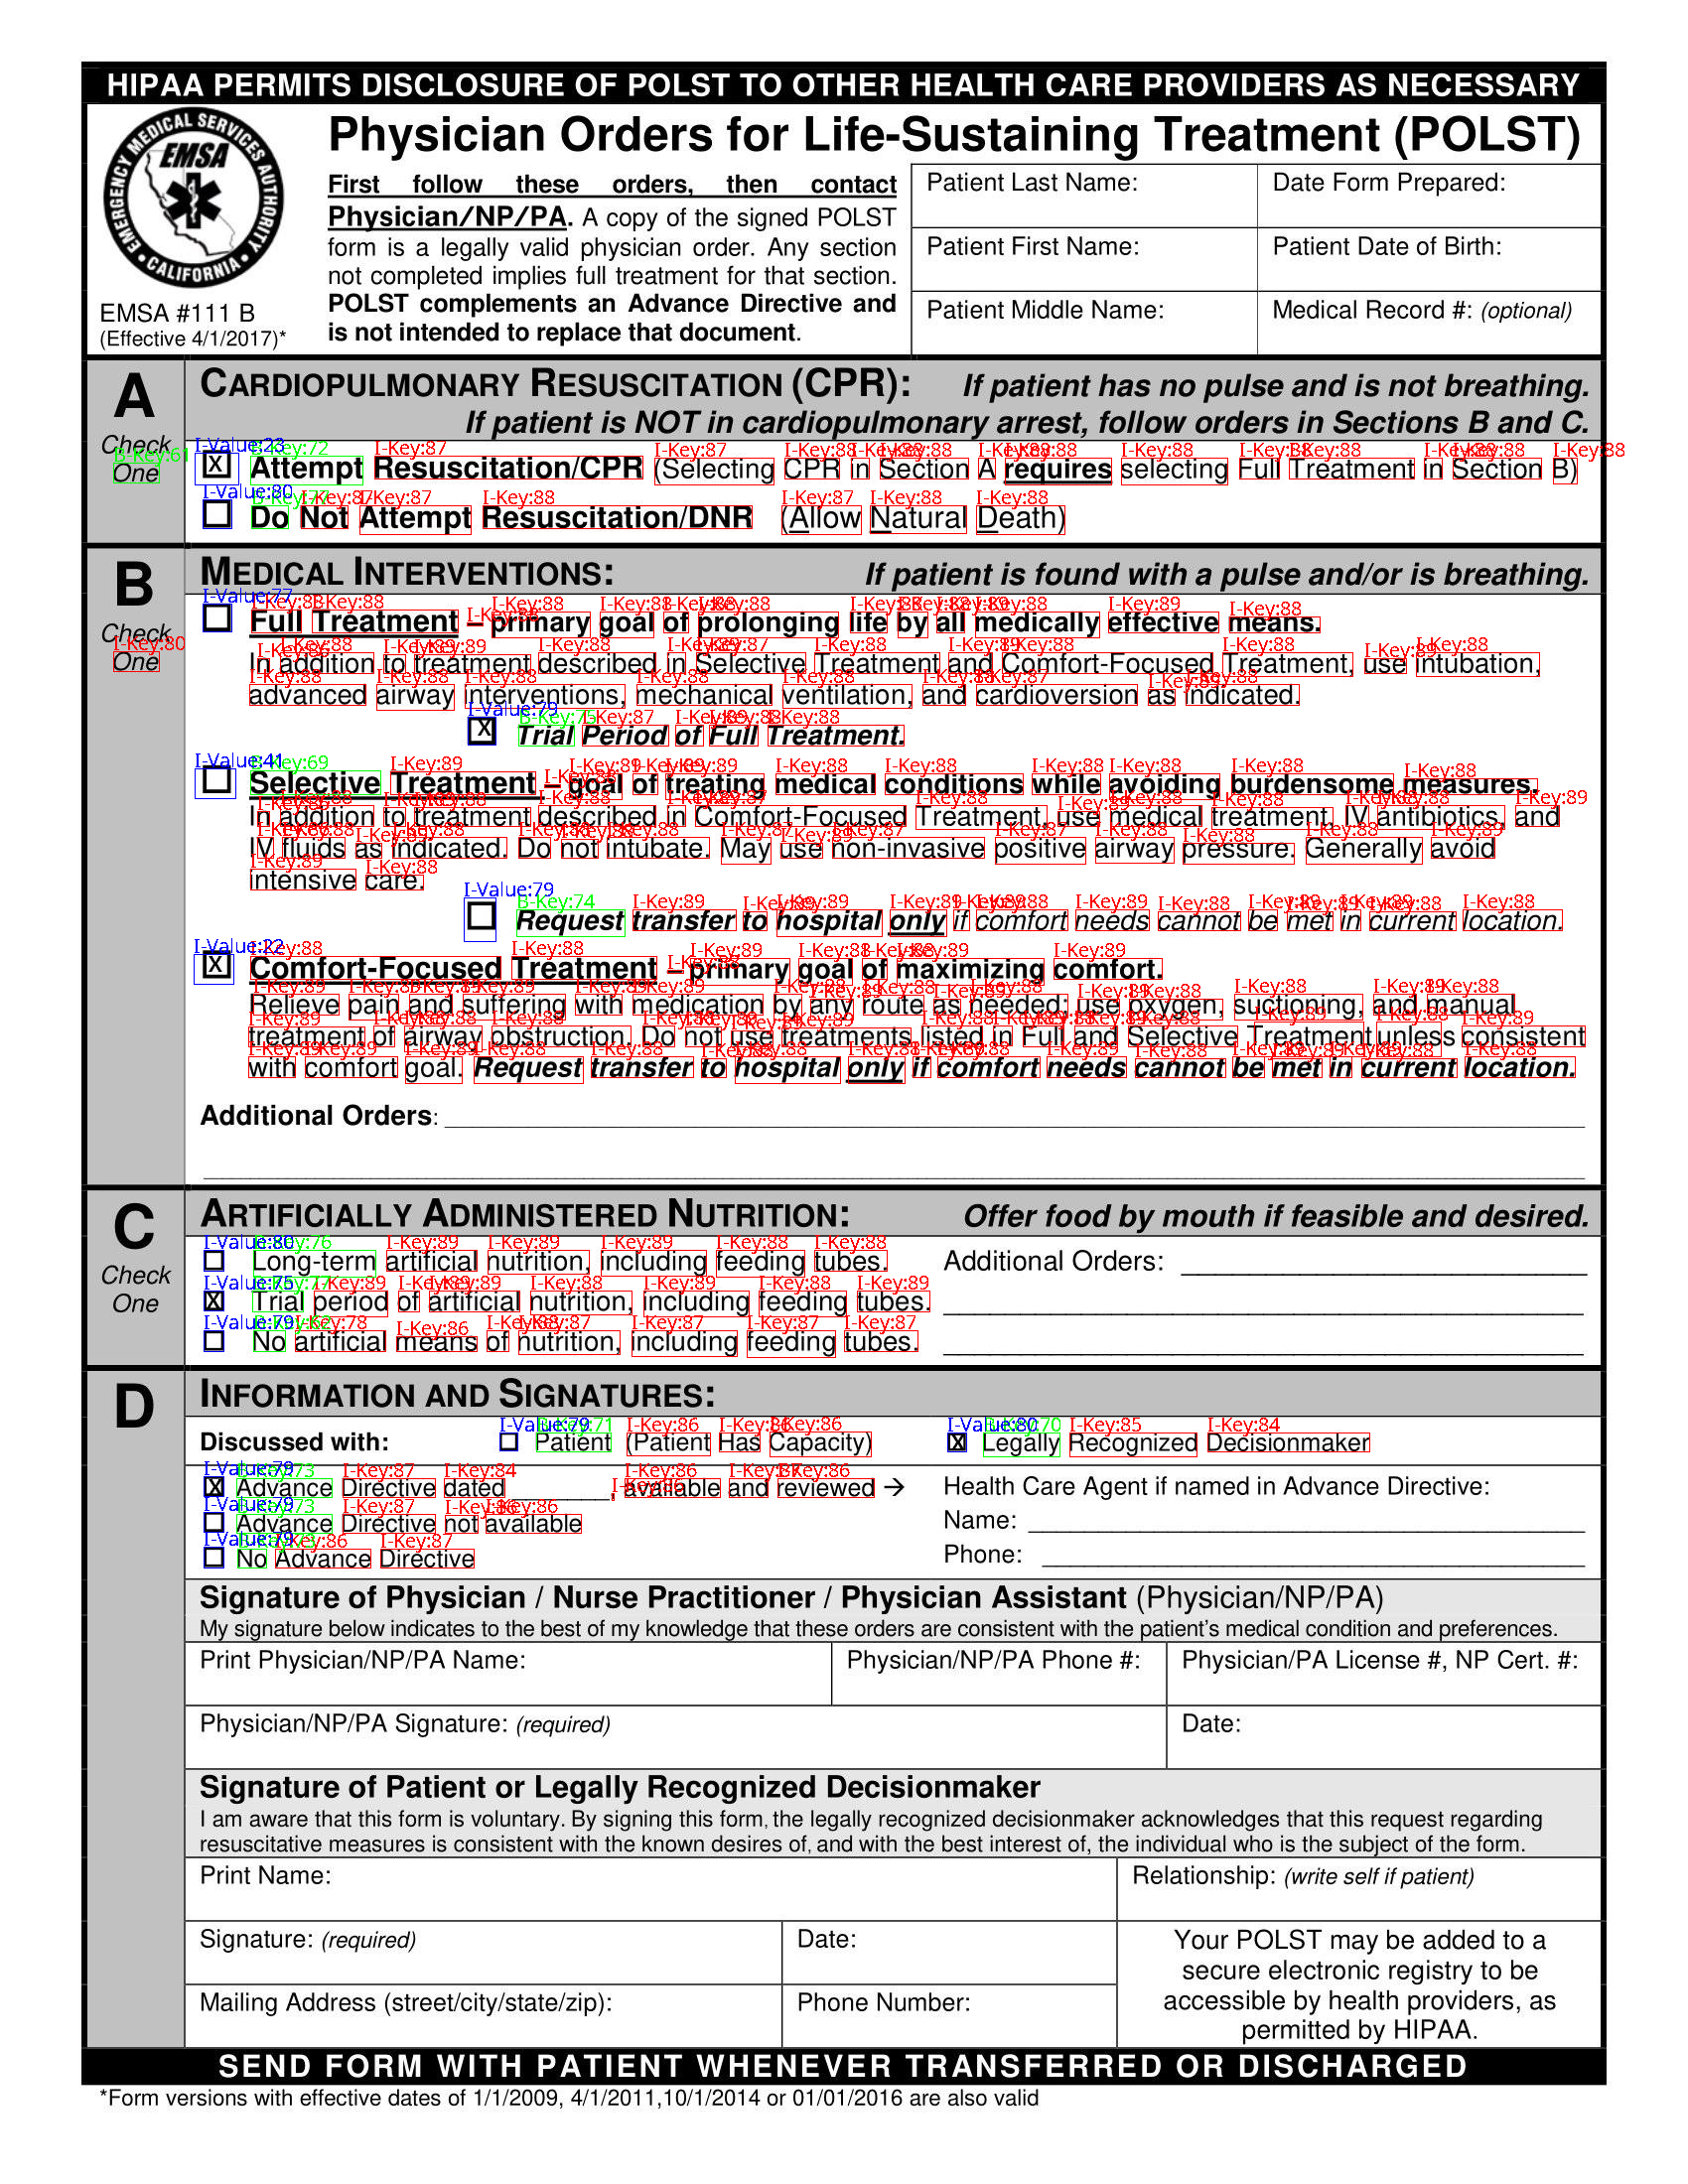

In [6]:
result = pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")

## Extract key/values

In [7]:
enttities = result.select("entities") \
     .withColumn("exploded_entities", f.explode("entities")) \
     .select("exploded_entities").collect()

In [8]:
# Clustered annotation by line
enttities_clustered = cluster(enttities, 10, key=lambda i: int(i.exploded_entities.metadata['y']))

# Sorted items in lines
enttities_sorted = [
    x
    for xs in enttities_clustered
    for x in sorted(xs, key=lambda i: int(i.exploded_entities.metadata['x'])) 
                    if int(int(x.exploded_entities.metadata['x']) > 150)
]

items = []
current = {}

# Group by key/value
for row in enttities_sorted:
    annotation = row.exploded_entities
    if annotation.result.endswith('Key'):
        if 'key' not in current:
            current['key'] = annotation.metadata['token']
        else:
            current['key'] = current['key'] + " " + annotation.metadata['token']
    else:
        if 'value' in current:
            items.append(current)
            current = {}
        current['value'] = annotation.metadata['token']

if 'value' in current:
    items.append(current)

# Transform to the dict
res = {i['key']:i['value'] for i in items if 'key' in i}

for key, value in res.items():
    print(f"* {key} - {value}\n")

* Attempt Resuscitation/CPR (Selecting CPR in Section A requires selecting Full Treatment in Section B) - yes

* Do Not Attempt Resuscitation/DNR (Allow Natural Death) - no

* Full Treatment - primary goal of prolonging life by all medically effective means. n addition to treatment described in Selective Treatment and Comfort-Focused Treatment, use intubation, advanced airway interventions, mechanical ventilation, and cardioversion as indicated. - no

* Trial Period of Full Treatment. - yes

* Selective Treatment — goal of treating medical conditions while avoiding burdensome measures. n addition to treatment described in Comfort-Focused Treatment, use medical treatment, IV antibiotics, and V fluids as indicated. Do not intubate. May use non-invasive positive airway pressure. Generally avoid intensive care. - no

* Request transfer to hospital only if comfort needs cannot be met in current location. - no

* Comfort-Focused Treatment primary goal of maximizing comfort. — Relieve pain an